# Missteering measurement

Measuring the vertical missteering at C171. Quick measurements seems to show that in this case the analytical law is respected (see PSMD logbook on May 16th).

The calibration for DVT50 from current to angle can be derived by:
```
Finding the current boundaries for DVT50 using YASP:
-200 urad = -3.25 A
-100 urad = -2.44 A
0 urad = -1.63 A
+100 urad = -0.82 A
+200 urad = -0.01 A 
```

**SECOND ATTEMPT TO MEASURE AFTER 16 MAY** --> there the V wirescanner was triggered at C181 for a mistake

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

from scipy.optimize import curve_fit

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.06.06
Your IP is 172.17.0.6
2018-07-02 09:36:43
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BPM.AcquisitionTrajectoryBBB.value.channelNames',
                'PR_BCT_ST.Samples.value.samples']



In [4]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 110 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data/2018.06.06.20.45.06.933.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data/2018.06.06.21.52.41.406.mat


In [5]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [6]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

No duplicates found
---
BPM data ok
---


# Load the DVT50 current settings 
Different files because comes from the PSB monitor

In [7]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data_PSB/'

matlabVars = ['AQN.current', # DVT50
                'CCV.current']

# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/PSB2018*.mat'))[:-1]
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

AQN_DVT50 = np.empty(len(files),dtype=float)
CCV_DVT50 = np.empty(len(files),dtype=float)

for k in range(len(files)):
    AQN_DVT50[k] = scipy.io.loadmat(files[k])['AQN'][0][0][0][0][0]
    CCV_DVT50[k] = scipy.io.loadmat(files[k])['CCV'][0][0][0][0][0]

Found 110 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data_PSB/PSB2018.06.06.20.44.44.558.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data_PSB/PSB2018.06.06.21.52.04.292.mat


In [8]:
myDataFrame['AQN_DVT50'] = AQN_DVT50
myDataFrame['CCV_DVT50'] = CCV_DVT50

# Import the optics model

In [6]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Booster emittance

In [10]:
# emix_norm_PSB = 2.484
# emiy_norm_PSB = 2.076

# emix_geom_PSB = emix_norm_PSB/(betar*gammar)
# emiy_geom_PSB = emiy_norm_PSB/(betar*gammar)

# Match the tomogram data

In [11]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [12]:
# new tomogram analysis
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/'
files_tomo=sorted(glob.glob(folderPath+'/tomo_data/*.dat'))

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_006.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_052.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_053.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_054.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_055.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_056.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_057.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_103.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_104.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_105.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_106.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_107.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_108.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_154.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_155.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_156.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_157.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_158.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_159.dat
/eos/project/l/liu/Instrumen

In [13]:
timeTolerance = 15

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


109/188 are within the timeTolerance
length of dataframe is: 110


In [14]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

# Save the imported data

In [15]:
myDataFrame.to_pickle('imported_data_2018.06.06.pkl')

In [10]:
# myDataFrame=pnd.read_pickle('imported_data_2018.06.06.pkl')

# Intensity

In [8]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )

Text(0,0.5,u'Peak intensity (10^10 ppb)')

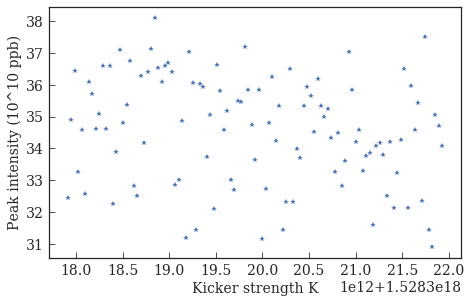

In [11]:
plt.plot(myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')

Text(0,0.5,u'Losses')

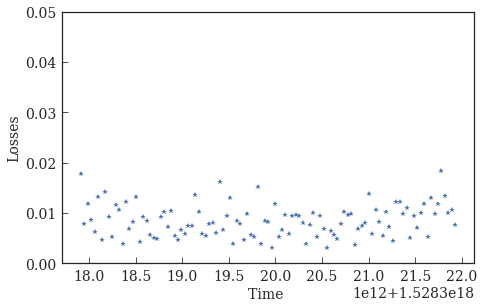

In [12]:
plt.plot(myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

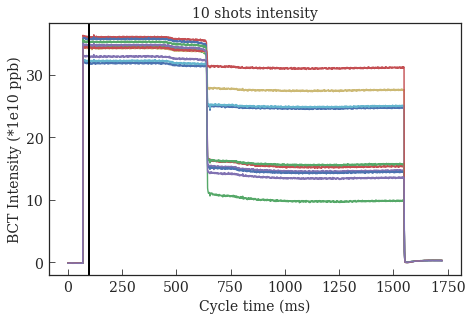

In [13]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [14]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [15]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

### Dispersive profile deconvolution

In [16]:
# BWS65
betax = 21.77988929
Dx = 3.24577470

betax = 20.11
Dx = 3.2

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile'],
                              row['deltaP_P'],
                              row['beta']*row['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


## Y plane

In [17]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [18]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

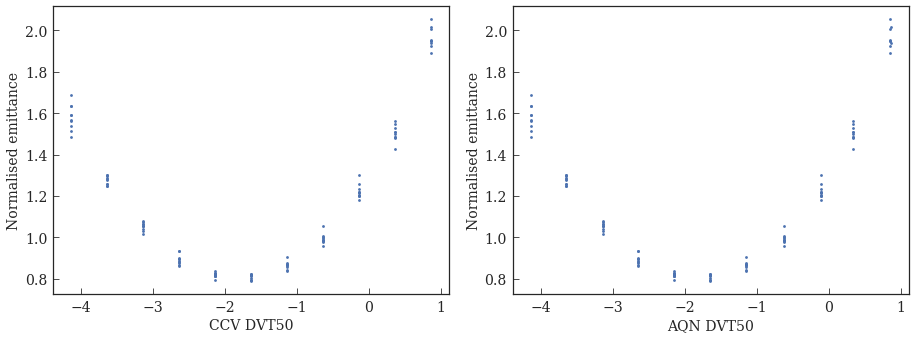

In [19]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

ax[0].plot(myDataFrame['CCV_DVT50'], myDataFrame['WS_emittance_y'],'.' )
ax[0].set_xlabel('CCV DVT50')
ax[0].set_ylabel('Normalised emittance')

ax[1].plot(myDataFrame['AQN_DVT50'], myDataFrame['WS_emittance_y'],'.' )
ax[1].set_xlabel('AQN DVT50')
ax[1].set_ylabel('Normalised emittance')

fig.tight_layout()

## Find a calibration curve for current --> angle of DVT50

In [20]:
# This time simpler, no reyasping happened
#data from YASP
angle = np.array([-0.2e-3,-0.1e-3,0.,0.1e-3,0.2e-3],dtype=float) 
current = np.array([-3.25,-2.44,-1.63,-0.82,-0.01],dtype=float)

#interpolation
params = np.polyfit(current,angle,1)
def interp_func(x):
    return params[0]*x + params[1]


In [21]:
myDataFrame['DVT50_kick'] = interp_func(myDataFrame['AQN_DVT50'])

Text(0,0.5,u'Normalised emittance (um)')

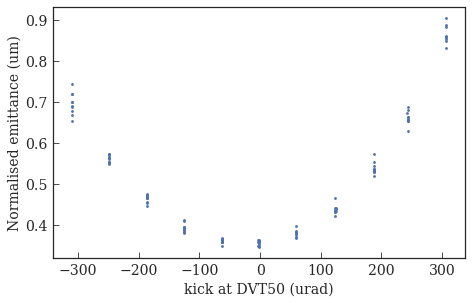

In [22]:
# so now in kick units
fig, ax = plt.subplots(1)

ax.plot(1e6*myDataFrame['DVT50_kick'], myDataFrame['WS_geom_emittance_y'],'.' )
ax.set_xlabel('kick at DVT50 (urad)')
ax.set_ylabel('Normalised emittance (um)')

## Calculate average emittance per measurement point

In [23]:
# find indexes of the shots at the same kick
ks = []
ks_idx = []
for k in range(len(myDataFrame)):
    if k == 0 :
        prevk = myDataFrame['DVT50_kick'].iloc[k]
        ks.append(prevk)
        ks_idx.append(k)
        continue
#     print(k)
    
    thisk = myDataFrame['DVT50_kick'].iloc[k]
    if (prevk-thisk) != 0:
#         print(thisk)
        ks.append(thisk)
        ks_idx.append(k)
    prevk = thisk

In [24]:
# manual adjusting
ks_idx = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [25]:
k_values = np.array((myDataFrame['DVT50_kick'].iloc[ks_idx]))

emix_mean = np.empty(len(ks_idx),dtype=float)
emiy_mean = np.empty(len(ks_idx),dtype=float)
emix_std = np.empty(len(ks_idx),dtype=float)
emiy_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]])



In [26]:
k_values

array([ -3.10078741e-04,  -2.48576402e-04,  -1.86471129e-04,
        -1.24968849e-04,  -6.34665101e-05,  -3.17015707e-06,
         5.95380795e-05,   1.24055221e-04,   1.88572328e-04,
         2.43442037e-04,   3.07356193e-04])

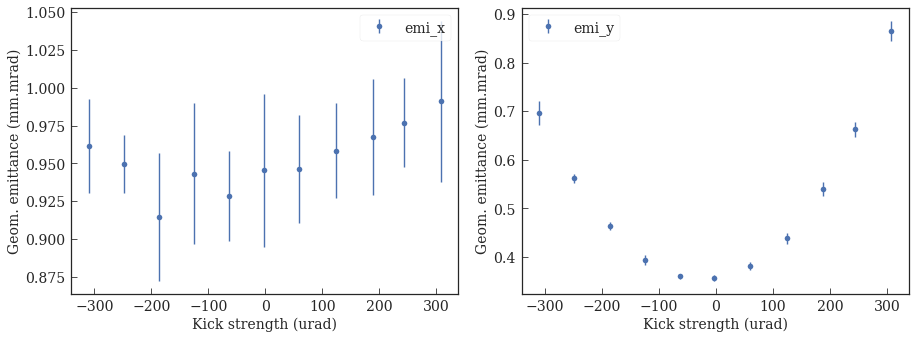

In [27]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

ax[0].errorbar(1e6*k_values, emix_mean, yerr=emix_std, fmt='o',label='emi_x')
ax[0].set_xlabel('Kick strength (urad)')
ax[0].set_ylabel('Geom. emittance (mm.mrad)')
ax[0].legend(frameon=True)

ax[1].errorbar(1e6*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')
ax[1].set_xlabel('Kick strength (urad)')
ax[1].set_ylabel('Geom. emittance (mm.mrad)')
ax[1].legend(frameon=True)

fig.tight_layout()

fig.savefig('Vert_steering_emi_xy.eps', format='eps',dpi=100)

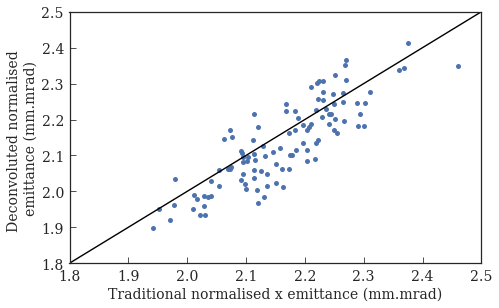

In [28]:
fig2, ax2 = plt.subplots(1)
ax2.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.',markersize=10)
plt.xlabel('Traditional normalised x emittance (mm.mrad)')
plt.ylabel('Deconvoluted normalised \nemittance (mm.mrad)')

ax2.plot([.5,10.],[.5,10.],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((1.8,2.5,1.8,2.5))

fig2.savefig('BCMS_under_coupling_Wemi_vs_deconv.eps', format='eps')

Model function: a(x - b)^2 + c
Fit params:
 a= 4.31611878034+/-0.0915097534708
 b= -2.61242572161e-05+/-1.93042691406e-06
 c= 3.52237258608e-07+/-2.62838867376e-09


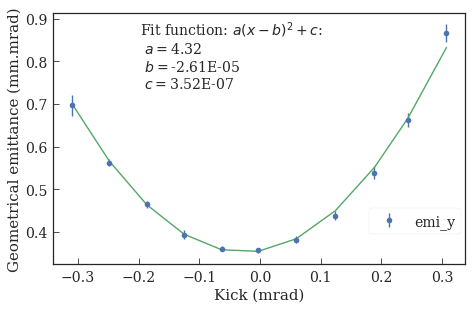

In [29]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = k_values
ydata = 1e-6*emiy_mean

fig, ax = plt.subplots(1)
ax.errorbar(1e3*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')

p, cov = curve_fit(f_to_fit,xdata,ydata,sigma=emiy_std)
err = np.sqrt(np.diag(cov))
# xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xdata, 1e6*f_to_fit(xdata,*p))


#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params:\n a= ' + str(p[0]) + '+/-' + str(err[0]) + '\n b= ' + str(p[1]) + '+/-' + str(err[1]) + '\n c= '+ str(p[2]) + '+/-' + str(err[2])


plt.xlabel('Kick (mrad)',fontsize=15)
plt.ylabel('Geometrical emittance (mm.mrad)',fontsize=15)

ax.text(0.21, 0.98, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0.7,2.3))
plt.legend(frameon=True,bbox_to_anchor=(0.75,.25))

fig.savefig('emi_xy_fitC171.eps', format='eps',dpi=100)

# BPMs

In [62]:
# BPMs
#add field for the first two turns and splitting x and y pickups, and turn to mm 
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,1])
myDataFrame['BPMx_turn3'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,2])
myDataFrame['BPMy_turn3'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,2])
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x[-43:,1])

# BPMS in order to compute the angles
def turnsForAngle(turn1, turn2, turn3):
    '''
    Put in row the BPM data as the beam sees them, so from BPM45 on.
    2 turns + 1st BPM of turn 3
    '''
    turn0 = turn1[18:]
    turn1 = np.concatenate((turn1[:18],turn2[18:]))
    turn2 = np.concatenate((turn2[:18],np.array([turn3[18]])))
    return np.concatenate((turn0,turn1,turn2))
    
myDataFrame['BPMx_2turns'] = [np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['BPMy_2turns'] = [np.empty(0,dtype=float)]*len(myDataFrame)
for k in myDataFrame.index:
    myDataFrame['BPMx_2turns'].loc[k] = turnsForAngle(myDataFrame['BPMx_turn1'].loc[k], myDataFrame['BPMx_turn2'].loc[k], myDataFrame['BPMx_turn3'].loc[k])# first two turns + first BPM of turn 3, starting from BPM45
    myDataFrame['BPMy_2turns'].loc[k] = turnsForAngle(myDataFrame['BPMy_turn1'].loc[k], myDataFrame['BPMy_turn2'].loc[k], myDataFrame['BPMy_turn3'].loc[k])# first two turns + first BPM of turn 3, starting from BPM45
    # set BPM43 to NaN  --> Just in X
    myDataFrame['BPMx_2turns'].loc[k][42] = np.NaN
    myDataFrame['BPMx_2turns'].loc[k][-2] = np.NaN
#     myDataFrame['BPMy_2turns'].loc[k][42] = np.NaN
#     myDataFrame['BPMy_2turns'].loc[k][-2] = np.NaN

In [63]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

# get the twiss at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []
BPM_betay = []
BPM_alphay = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])
        BPM_betay.append(optics.BETA22[k])   
        BPM_alphay.append(optics.ALFA22[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]
BPM_betay = [BPM_betay[-1]] + BPM_betay[:-1]
BPM_alphay = [BPM_alphay[-1]] + BPM_alphay[:-1]

# casting stuff
BPM_betax = np.array(BPM_betax)
BPM_alphax = np.array(BPM_alphax)
BPM_betay = np.array(BPM_betay)
BPM_alphay = np.array(BPM_alphay)

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


## Get the transfer matrix between the BPMs

So for example for BPM00 and BPM03

$$
\begin{pmatrix}
  x  \\
  x^\prime
 \end{pmatrix}_\text{BPM00}
=
\begin{pmatrix}
  a & b \\
  c & d
 \end{pmatrix}
\begin{pmatrix}
  x  \\
  x^\prime
 \end{pmatrix}_\text{BPM03}
$$

so the angle at the first BPM can be obtained just from the position at the two, if the optics model is known
$$
x^\prime_\text{BPM00} = c x_\text{BPM00} + \frac{d}{b} (x_\text{BPM03} - a x_\text{BPM00})
$$


In [64]:
# load transfer matrixes
X_TM = [] # --> X_TM[0] is the matrix between BPM03 and BPM00
Y_TM = []

for k in range(43):
    fname = 'sector'+str(k)+'.sec'
    imported_twiss = metaclass.twiss('/eos/user/e/esenes/PS-injection-steering/MADx/transfer_matrix_BPMs/'+fname)

    x_transfer_matrix = np.matrix([[imported_twiss.R11[-1], imported_twiss.R12[-1]],[imported_twiss.R21[-1], imported_twiss.R22[-1]]],dtype=float)
    y_transfer_matrix = np.matrix([[imported_twiss.R33[-1],imported_twiss.R34[-1]],[imported_twiss.R43[-1],imported_twiss.R44[-1]]],dtype=float)

    X_TM.append(x_transfer_matrix)
    Y_TM.append(y_transfer_matrix)

print('Done.')

Done.


In [65]:
def getAngle(transfer_matrix, thisBPM, nextBPM):
    a = transfer_matrix[0,0]
    b = transfer_matrix[0,1]
    c = transfer_matrix[1,0]
    d = transfer_matrix[1,1]
    return (c*thisBPM) + ((d/b)*(nextBPM - (a*thisBPM)))

## Get the angles for the first two turns

In [89]:
# prepare the storage
myDataFrame['BPMy_2turns_angles'] = [np.empty(0,dtype=float)]*len(myDataFrame)

for j in myDataFrame.index:

    bpmData = myDataFrame['BPMy_2turns'].loc[j]
    angles = []

    for k in range(len(bpmData)-1):

        idx_tm = np.mod(k, len(Y_TM))    
        transfer_matrix = Y_TM[idx_tm]

        if k < len(bpmData)-1:
            angles.append(getAngle(transfer_matrix, bpmData[k], bpmData[k+1]))

    # casting and add a NaN to match the length
    angles.append(np.NaN)
    angles = np.array(angles,dtype=float)

    # put it in the dataframe
    myDataFrame['BPMy_2turns_angles'].loc[j] = angles

In [93]:
# prepare the storage
myDataFrame['BPMx_2turns_angles'] = [np.empty(0,dtype=float)]*len(myDataFrame)

for j in myDataFrame.index:

    bpmData = myDataFrame['BPMx_2turns'].loc[j]
    angles = []

    for k in range(len(bpmData)-1):

        idx_tm = np.mod(k, len(X_TM))    
        transfer_matrix = X_TM[idx_tm]

        if k < len(bpmData)-1:
            angles.append(getAngle(transfer_matrix, bpmData[k], bpmData[k+1]))

    # casting and add a NaN to match the length
    angles.append(np.NaN)
    angles = np.array(angles,dtype=float)

    # put it in the dataframe
    myDataFrame['BPMx_2turns_angles'].loc[j] = angles

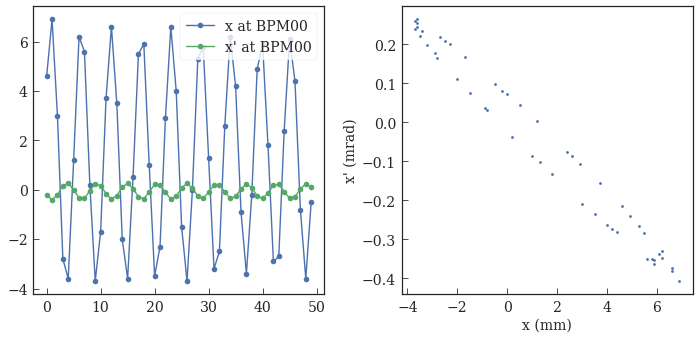

In [126]:
k=0
off = 43
m = 0
ydata1 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,:50]).values[k] #thisBPM
ydata2 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m+1,:50]).values[k] #nextBPM

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(ydata1,'o-',label='x at BPM00')

angles = getAngle(X_TM[0], ydata1, ydata2)

ax[0].plot(angles,'o-',label='x\' at BPM00')
ax[0].legend(frameon=True, loc=1)

ax[1].plot(ydata1, angles,'.')
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('x\' (mrad)')

fig.tight_layout()

In [127]:
angles

array([-0.2154147 , -0.40684157, -0.2083648 ,  0.16343114,  0.26343288,
        0.00308453, -0.32930666, -0.34918749, -0.03696037,  0.23805998,
        0.16825195, -0.15673244, -0.38090219, -0.23458742,  0.10967447,
        0.25545959,  0.04553697, -0.2836649 , -0.36236961, -0.08593306,
        0.2202355 ,  0.20099482, -0.10616508, -0.3729289 , -0.26399936,
        0.07547856,  0.25879053,  0.0717596 , -0.26584043, -0.35106539,
       -0.1023045 ,  0.19908009,  0.2076567 , -0.08660433, -0.3468479 ,
       -0.27225589,  0.03635705,  0.2344458 ,  0.08001613, -0.23975942,
       -0.35280167, -0.1333111 ,  0.17792468,  0.21750788, -0.07515849,
       -0.33713833, -0.28051242,  0.03143146,  0.24429699,  0.09798222])

# Calculate injection oscillation from the BPM


!!! It's all modified, beatx and alfx are actually the vertical values !

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [72]:
# loop over all the BPM --> in vertical ! 
verticalMode = True

if verticalMode:
    off = 43
else:
    off = 0

chi2_thr = 0.5    
    
# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
        # starting values
        phase = 0.33*pi
        p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
        # fit boundaries 
        bounds=([0.5*np.std(ydata), .8*pi/5, -pi, -np.inf],[3*np.std(ydata),pi/2.,pi,np.inf])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
            while chi2[k,m] > chi2_thr:
                print('chi2 = '+str(chi2[k,m])+' exceding the limit')

                phase += 0.03
                p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
                p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
                osc_amplitude[k,m] = np.abs(p[0])

                yfit = f_to_fit(xdata, *p)
                chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
                print('Refitting, new chi2 = '+str(chi2[k,m]))
                
                if phase > 0.45*pi:
                    print('END phase reached')
                    raise RuntimeError


        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

chi2 = 13.1552236886 exceding the limit
Refitting, new chi2 = 0.0223442573079
chi2 = 12.9982494684 exceding the limit
Refitting, new chi2 = 0.019618761885
chi2 = 13.5154943813 exceding the limit
Refitting, new chi2 = 0.00901803803173
chi2 = 13.2523024735 exceding the limit
Refitting, new chi2 = 0.0229086022712
chi2 = 12.9396576579 exceding the limit
Refitting, new chi2 = 0.0129407271688
chi2 = 12.832452901 exceding the limit
Refitting, new chi2 = 0.0219940074715
chi2 = 13.2595524751 exceding the limit
Refitting, new chi2 = 0.00825445890316
chi2 = 13.2323717066 exceding the limit
Refitting, new chi2 = 0.0205874115112
chi2 = 13.1335857819 exceding the limit
Refitting, new chi2 = 0.0118108643419
chi2 = 13.1011715126 exceding the limit
Refitting, new chi2 = 0.00991069454856
chi2 = 8.27888694619 exceding the limit
Refitting, new chi2 = 0.0100527653282
chi2 = 8.26710945283 exceding the limit
Refitting, new chi2 = 0.00971661073327
chi2 = 8.17396381077 exceding the limit
Refitting, new chi2 = 

PR.BPM03 processed with success 109/109 shots
PR.BPM05 processed with success 109/109 shots
chi2 = 0.770090388733 exceding the limit
Refitting, new chi2 = 0.00613884175361
chi2 = 0.689931784629 exceding the limit
Refitting, new chi2 = 0.00498764186022
chi2 = 0.671320887579 exceding the limit
Refitting, new chi2 = 0.00524946980799
chi2 = 0.726176389494 exceding the limit
Refitting, new chi2 = 0.00862505238394
chi2 = 0.763913011328 exceding the limit
Refitting, new chi2 = 0.00829588279553
chi2 = 0.658458763664 exceding the limit
Refitting, new chi2 = 0.00626503341945
chi2 = 0.653560542585 exceding the limit
Refitting, new chi2 = 0.00723424252118
chi2 = 0.6556367163 exceding the limit
Refitting, new chi2 = 0.00528126340726
chi2 = 0.660254376671 exceding the limit
Refitting, new chi2 = 0.00552612469248
chi2 = 0.774985918944 exceding the limit
Refitting, new chi2 = 0.00734086534565
chi2 = 2.04981681766 exceding the limit
Refitting, new chi2 = 0.00474885542143
chi2 = 2.05500675636 exceding t

Refitting, new chi2 = 5.07510644641
chi2 = 5.07510644641 exceding the limit
Refitting, new chi2 = 11.426700224
chi2 = 11.426700224 exceding the limit
Refitting, new chi2 = 0.00848460577777
chi2 = 4.87421579178 exceding the limit
Refitting, new chi2 = 4.87421579179
chi2 = 4.87421579179 exceding the limit
Refitting, new chi2 = 0.00554384000016
chi2 = 7.64725773527 exceding the limit
Refitting, new chi2 = 7.64725773467
chi2 = 7.64725773467 exceding the limit
Refitting, new chi2 = 0.00775127921916
chi2 = 7.71434125832 exceding the limit
Refitting, new chi2 = 7.7143412558
chi2 = 7.7143412558 exceding the limit
Refitting, new chi2 = 0.00701640717698
chi2 = 7.64152576531 exceding the limit
Refitting, new chi2 = 7.64152576544
chi2 = 7.64152576544 exceding the limit
Refitting, new chi2 = 0.0180759841584
chi2 = 7.79752291019 exceding the limit
Refitting, new chi2 = 7.79752291031
chi2 = 7.79752291031 exceding the limit
Refitting, new chi2 = 0.0120642347545
chi2 = 7.60543325319 exceding the limit


chi2 = 2.08662123963 exceding the limit
Refitting, new chi2 = 2.08662123966
chi2 = 2.08662123966 exceding the limit
Refitting, new chi2 = 2.08662123962
chi2 = 2.08662123962 exceding the limit
Refitting, new chi2 = 8.06837843211
chi2 = 8.06837843211 exceding the limit
Refitting, new chi2 = 0.00583162299017
chi2 = 2.07048078486 exceding the limit
Refitting, new chi2 = 2.07048078496
chi2 = 2.07048078496 exceding the limit
Refitting, new chi2 = 2.07048078487
chi2 = 2.07048078487 exceding the limit
Refitting, new chi2 = 2.07048078489
chi2 = 2.07048078489 exceding the limit
Refitting, new chi2 = 0.0133476321097
chi2 = 2.02194809998 exceding the limit
Refitting, new chi2 = 2.02194809999
chi2 = 2.02194809999 exceding the limit
Refitting, new chi2 = 2.02194809997
chi2 = 2.02194809997 exceding the limit
Refitting, new chi2 = 8.0900504171
chi2 = 8.0900504171 exceding the limit
Refitting, new chi2 = 0.00508796429139
chi2 = 1.96842468015 exceding the limit
Refitting, new chi2 = 1.96842468016
chi2 =

chi2 = 1.71761139235 exceding the limit
Refitting, new chi2 = 0.00518241108226
chi2 = 1.646934246 exceding the limit
Refitting, new chi2 = 0.0070371302203
chi2 = 1.66213162271 exceding the limit
Refitting, new chi2 = 0.00339052338915
chi2 = 1.68411916606 exceding the limit
Refitting, new chi2 = 0.00872218548186
chi2 = 1.60225672583 exceding the limit
Refitting, new chi2 = 0.00489712082441
chi2 = 1.64629191749 exceding the limit
Refitting, new chi2 = 0.00387876929666
chi2 = 1.64061180413 exceding the limit
Refitting, new chi2 = 0.00617658156063
chi2 = 3.22250243618 exceding the limit
Refitting, new chi2 = 0.00541687671521
chi2 = 3.3535937591 exceding the limit
Refitting, new chi2 = 0.0048545849143
chi2 = 3.27374704236 exceding the limit
Refitting, new chi2 = 0.00507956400622
chi2 = 3.42199059303 exceding the limit
Refitting, new chi2 = 0.00390252269152
chi2 = 3.17162255306 exceding the limit
Refitting, new chi2 = 0.00419196469868
chi2 = 3.16557752877 exceding the limit
Refitting, new ch

chi2 = 1.03223310041 exceding the limit
Refitting, new chi2 = 1.03223310046
chi2 = 1.03223310046 exceding the limit
Refitting, new chi2 = 1.03223310043
chi2 = 1.03223310043 exceding the limit
Refitting, new chi2 = 3.72359795348
chi2 = 3.72359795348 exceding the limit
Refitting, new chi2 = 0.0101176130011
chi2 = 1.01986643004 exceding the limit
Refitting, new chi2 = 1.01986643004
chi2 = 1.01986643004 exceding the limit
Refitting, new chi2 = 1.01986643004
chi2 = 1.01986643004 exceding the limit
Refitting, new chi2 = 3.71524358439
chi2 = 3.71524358439 exceding the limit
Refitting, new chi2 = 0.0077280870815
chi2 = 1.04319635697 exceding the limit
Refitting, new chi2 = 1.04319635697
chi2 = 1.04319635697 exceding the limit
Refitting, new chi2 = 1.04319635696
chi2 = 1.04319635696 exceding the limit
Refitting, new chi2 = 3.69962984786
chi2 = 3.69962984786 exceding the limit
Refitting, new chi2 = 0.00497210008324
chi2 = 1.04321926876 exceding the limit
Refitting, new chi2 = 1.04321926876
chi2 

PR.BPM30 processed with success 109/109 shots
chi2 = 8.18599685569 exceding the limit
Refitting, new chi2 = 0.0088323800493
chi2 = 8.26002761892 exceding the limit
Refitting, new chi2 = 0.00908527397141
chi2 = 8.61427626903 exceding the limit
Refitting, new chi2 = 0.00869925845993
chi2 = 8.36649715708 exceding the limit
Refitting, new chi2 = 0.00793628124964
chi2 = 8.31436987766 exceding the limit
Refitting, new chi2 = 0.0120686687758
chi2 = 8.15843046257 exceding the limit
Refitting, new chi2 = 0.00790813953339
chi2 = 8.36848551268 exceding the limit
Refitting, new chi2 = 0.00861256585692
chi2 = 8.37885280887 exceding the limit
Refitting, new chi2 = 0.00998465447803
chi2 = 8.51470597025 exceding the limit
Refitting, new chi2 = 0.00615117383608
chi2 = 8.34134176903 exceding the limit
Refitting, new chi2 = 0.00617914213779
chi2 = 5.2925012714 exceding the limit
Refitting, new chi2 = 0.00495253566614
chi2 = 5.31549330971 exceding the limit
Refitting, new chi2 = 0.00640020701764
chi2 = 5.

Refitting, new chi2 = 0.552237025618
chi2 = 0.552237025618 exceding the limit
Refitting, new chi2 = 0.00513063238448
chi2 = 0.554307195474 exceding the limit
Refitting, new chi2 = 0.554307195466
chi2 = 0.554307195466 exceding the limit
Refitting, new chi2 = 0.0036784878025
chi2 = 0.511739870167 exceding the limit
Refitting, new chi2 = 0.806128660768
chi2 = 0.806128660768 exceding the limit
Refitting, new chi2 = 0.00811916120172
chi2 = 0.547655045899 exceding the limit
Refitting, new chi2 = 0.547655045515
chi2 = 0.547655045515 exceding the limit
Refitting, new chi2 = 0.00510526230888
chi2 = 0.543550450092 exceding the limit
Refitting, new chi2 = 0.832007485691
chi2 = 0.832007485691 exceding the limit
Refitting, new chi2 = 0.00640133517237
chi2 = 0.541687718292 exceding the limit
Refitting, new chi2 = 0.541687718337
chi2 = 0.541687718337 exceding the limit
Refitting, new chi2 = 0.00532070725433
chi2 = 0.514977198566 exceding the limit
Refitting, new chi2 = 0.514977198815
chi2 = 0.5149771

chi2 = 11.7753216381 exceding the limit
Refitting, new chi2 = 0.00931311816531
chi2 = 12.2150483904 exceding the limit
Refitting, new chi2 = 0.00983374664906
chi2 = 12.3658104645 exceding the limit
Refitting, new chi2 = 0.0146623582944
chi2 = 12.4010410025 exceding the limit
Refitting, new chi2 = 0.00666840511264
chi2 = 12.2762829435 exceding the limit
Refitting, new chi2 = 0.0118477213552
chi2 = 18.4063714596 exceding the limit
Refitting, new chi2 = 0.0210421169795
chi2 = 18.2976703103 exceding the limit
Refitting, new chi2 = 0.0110183035181
chi2 = 18.2197235379 exceding the limit
Refitting, new chi2 = 0.00877226142792
chi2 = 18.4788805896 exceding the limit
Refitting, new chi2 = 0.0112455609977
chi2 = 18.6438553705 exceding the limit
Refitting, new chi2 = 0.0195537815304
chi2 = 18.0762911573 exceding the limit
Refitting, new chi2 = 0.0152938350537
chi2 = 18.7009567203 exceding the limit
Refitting, new chi2 = 0.0165722035025
chi2 = 18.5817677216 exceding the limit
Refitting, new chi2 

Refitting, new chi2 = 0.00704491989039
chi2 = 5.21825367294 exceding the limit
Refitting, new chi2 = 5.21825367388
chi2 = 5.21825367388 exceding the limit
Refitting, new chi2 = 0.0133886357926
chi2 = 5.09041035254 exceding the limit
Refitting, new chi2 = 5.0904103553
chi2 = 5.0904103553 exceding the limit
Refitting, new chi2 = 0.010070489709
chi2 = 5.2221206883 exceding the limit
Refitting, new chi2 = 5.22212069085
chi2 = 5.22212069085 exceding the limit
Refitting, new chi2 = 0.0144095163059
chi2 = 5.18577624032 exceding the limit
Refitting, new chi2 = 5.18577624272
chi2 = 5.18577624272 exceding the limit
Refitting, new chi2 = 0.0115486128238
chi2 = 5.21053436081 exceding the limit
Refitting, new chi2 = 5.2105343607
chi2 = 5.2105343607 exceding the limit
Refitting, new chi2 = 0.0196094174905
chi2 = 5.06089113284 exceding the limit
Refitting, new chi2 = 5.06089113057
chi2 = 5.06089113057 exceding the limit
Refitting, new chi2 = 0.0114037033747
chi2 = 5.2627287899 exceding the limit
Refi

Refitting, new chi2 = 0.00779457865482
chi2 = 1.61153241199 exceding the limit
Refitting, new chi2 = 1.61153241199
chi2 = 1.61153241199 exceding the limit
Refitting, new chi2 = 1.61153241199
chi2 = 1.61153241199 exceding the limit
Refitting, new chi2 = 1.61153241199
chi2 = 1.61153241199 exceding the limit
Refitting, new chi2 = 9.54761858925
chi2 = 9.54761858925 exceding the limit
Refitting, new chi2 = 0.00498771266747
chi2 = 1.57875003412 exceding the limit
Refitting, new chi2 = 1.57875003413
chi2 = 1.57875003413 exceding the limit
Refitting, new chi2 = 1.57875003412
chi2 = 1.57875003412 exceding the limit
Refitting, new chi2 = 1.57875003413
chi2 = 1.57875003413 exceding the limit
Refitting, new chi2 = 9.42972955946
chi2 = 9.42972955946 exceding the limit
Refitting, new chi2 = 0.00586570072493
chi2 = 1.5860513308 exceding the limit
Refitting, new chi2 = 1.5860513308
chi2 = 1.5860513308 exceding the limit
Refitting, new chi2 = 1.5860513308
chi2 = 1.5860513308 exceding the limit
Refittin

Refitting, new chi2 = 0.00671396374741
chi2 = 4.14190693522 exceding the limit
Refitting, new chi2 = 4.14190693614
chi2 = 4.14190693614 exceding the limit
Refitting, new chi2 = 0.00463633009478
chi2 = 4.08563829046 exceding the limit
Refitting, new chi2 = 4.08563829086
chi2 = 4.08563829086 exceding the limit
Refitting, new chi2 = 0.00436821884314
chi2 = 4.13011036913 exceding the limit
Refitting, new chi2 = 4.13011036873
chi2 = 4.13011036873 exceding the limit
Refitting, new chi2 = 0.00510085139052
chi2 = 4.11008965796 exceding the limit
Refitting, new chi2 = 4.11008965898
chi2 = 4.11008965898 exceding the limit
Refitting, new chi2 = 7.41193847253
chi2 = 7.41193847253 exceding the limit
Refitting, new chi2 = 0.0064004857103
chi2 = 4.07371118997 exceding the limit
Refitting, new chi2 = 4.07371119049
chi2 = 4.07371119049 exceding the limit
Refitting, new chi2 = 0.00741678817192
chi2 = 4.08155404017 exceding the limit
Refitting, new chi2 = 4.08155404054
chi2 = 4.08155404054 exceding the l

Refitting, new chi2 = 1.3868779256
chi2 = 1.3868779256 exceding the limit
Refitting, new chi2 = 1.38687792549
chi2 = 1.38687792549 exceding the limit
Refitting, new chi2 = 0.00893107734576
chi2 = 1.34566387759 exceding the limit
Refitting, new chi2 = 1.34566387764
chi2 = 1.34566387764 exceding the limit
Refitting, new chi2 = 1.3456638776
chi2 = 1.3456638776 exceding the limit
Refitting, new chi2 = 0.00394372884785
chi2 = 1.35473756271 exceding the limit
Refitting, new chi2 = 1.35473756274
chi2 = 1.35473756274 exceding the limit
Refitting, new chi2 = 1.35473756283
chi2 = 1.35473756283 exceding the limit
Refitting, new chi2 = 0.0041170711171
chi2 = 1.34154170439 exceding the limit
Refitting, new chi2 = 1.34154170431
chi2 = 1.34154170431 exceding the limit
Refitting, new chi2 = 1.34154170428
chi2 = 1.34154170428 exceding the limit
Refitting, new chi2 = 0.00452741186802
chi2 = 1.34904470621 exceding the limit
Refitting, new chi2 = 1.34904470615
chi2 = 1.34904470615 exceding the limit
Refit

Refitting, new chi2 = 0.0115761700603
chi2 = 7.93744443478 exceding the limit
Refitting, new chi2 = 0.0114181386723
chi2 = 12.303778279 exceding the limit
Refitting, new chi2 = 0.0192679839369
chi2 = 16.1633027231 exceding the limit
Refitting, new chi2 = 0.0108695651475
chi2 = 12.032885141 exceding the limit
Refitting, new chi2 = 0.0158444076754
chi2 = 16.3178184671 exceding the limit
Refitting, new chi2 = 0.013165849532
chi2 = 16.1688452129 exceding the limit
Refitting, new chi2 = 0.0224675210047
chi2 = 15.756721275 exceding the limit
Refitting, new chi2 = 0.0199377463845
chi2 = 16.0790026955 exceding the limit
Refitting, new chi2 = 0.0174963903076
chi2 = 16.1819200893 exceding the limit
Refitting, new chi2 = 0.0125582672561
chi2 = 16.3564129663 exceding the limit
Refitting, new chi2 = 0.021754233387
PR.BPM60 processed with success 109/109 shots
chi2 = 0.679688808076 exceding the limit
Refitting, new chi2 = 0.67968880808
chi2 = 0.67968880808 exceding the limit
Refitting, new chi2 = 0.

Refitting, new chi2 = 8.84273319702
chi2 = 8.84273319702 exceding the limit
Refitting, new chi2 = 0.00509289358103
chi2 = 1.89584100143 exceding the limit
Refitting, new chi2 = 1.89584100145
chi2 = 1.89584100145 exceding the limit
Refitting, new chi2 = 1.89584100143
chi2 = 1.89584100143 exceding the limit
Refitting, new chi2 = 1.89584100143
chi2 = 1.89584100143 exceding the limit
Refitting, new chi2 = 8.7321093013
chi2 = 8.7321093013 exceding the limit
Refitting, new chi2 = 0.00844284677823
chi2 = 1.87569156888 exceding the limit
Refitting, new chi2 = 1.87569156889
chi2 = 1.87569156889 exceding the limit
Refitting, new chi2 = 1.87569156888
chi2 = 1.87569156888 exceding the limit
Refitting, new chi2 = 9.02826685095
chi2 = 9.02826685095 exceding the limit
Refitting, new chi2 = 0.00791788239863
chi2 = 1.87345636434 exceding the limit
Refitting, new chi2 = 1.87345636434
chi2 = 1.87345636434 exceding the limit
Refitting, new chi2 = 1.87345636434
chi2 = 1.87345636434 exceding the limit
Refit

Refitting, new chi2 = 0.998712164649
chi2 = 0.998712164649 exceding the limit
Refitting, new chi2 = 14.2479988522
chi2 = 14.2479988522 exceding the limit
Refitting, new chi2 = 14.2479988517
chi2 = 14.2479988517 exceding the limit
Refitting, new chi2 = 0.00812828147351
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 1.00983656619
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 1.00983656619
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 1.00983656619
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 14.4725893954
chi2 = 14.4725893954 exceding the limit
Refitting, new chi2 = 14.4725893953
chi2 = 14.4725893953 exceding the limit
Refitting, new chi2 = 0.0067103824857
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 1.03684154303
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 1.03684154303
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 1.03684154303
chi2 = 1.03684154303 exceding the limit
Refit

Refitting, new chi2 = 5.47964462782
chi2 = 5.47964462782 exceding the limit
Refitting, new chi2 = 0.00889430127661
chi2 = 5.60600549943 exceding the limit
Refitting, new chi2 = 5.60600550069
chi2 = 5.60600550069 exceding the limit
Refitting, new chi2 = 0.00988504646131
chi2 = 3.56658112724 exceding the limit
Refitting, new chi2 = 3.56658112547
chi2 = 3.56658112547 exceding the limit
Refitting, new chi2 = 0.00707448272129
chi2 = 3.47111419857 exceding the limit
Refitting, new chi2 = 3.47111419847
chi2 = 3.47111419847 exceding the limit
Refitting, new chi2 = 0.0110172102239
chi2 = 3.53759949089 exceding the limit
Refitting, new chi2 = 3.53759948929
chi2 = 3.53759948929 exceding the limit
Refitting, new chi2 = 0.00546689987548
chi2 = 3.57863999363 exceding the limit
Refitting, new chi2 = 3.57863999364
chi2 = 3.57863999364 exceding the limit
Refitting, new chi2 = 0.00673016469155
chi2 = 3.55078216645 exceding the limit
Refitting, new chi2 = 3.55078216542
chi2 = 3.55078216542 exceding the l

chi2 = 8.18284020139 exceding the limit
Refitting, new chi2 = 0.0101877558427
chi2 = 8.52829350068 exceding the limit
Refitting, new chi2 = 0.00655847980305
chi2 = 8.39019656238 exceding the limit
Refitting, new chi2 = 0.0065041204858
chi2 = 8.59920855053 exceding the limit
Refitting, new chi2 = 0.00811553961242
PR.BPM75 processed with success 109/109 shots
chi2 = 0.912652378325 exceding the limit
Refitting, new chi2 = 0.912652378183
chi2 = 0.912652378183 exceding the limit
Refitting, new chi2 = 0.00790587635927
chi2 = 0.914022917916 exceding the limit
Refitting, new chi2 = 0.914022917877
chi2 = 0.914022917877 exceding the limit
Refitting, new chi2 = 0.00263023083636
chi2 = 0.936358329077 exceding the limit
Refitting, new chi2 = 0.93635832898
chi2 = 0.93635832898 exceding the limit
Refitting, new chi2 = 0.00519625828842
chi2 = 0.925444140674 exceding the limit
Refitting, new chi2 = 0.925444140669
chi2 = 0.925444140669 exceding the limit
Refitting, new chi2 = 0.00469495423957
chi2 = 0.9

Refitting, new chi2 = 0.00524846064551
chi2 = 0.509310132145 exceding the limit
Refitting, new chi2 = 0.509310132145
chi2 = 0.509310132145 exceding the limit
Refitting, new chi2 = 0.509310132145
chi2 = 0.509310132145 exceding the limit
Refitting, new chi2 = 0.509310132145
chi2 = 0.509310132145 exceding the limit
Refitting, new chi2 = 6.98634152767
chi2 = 6.98634152767 exceding the limit
Refitting, new chi2 = 6.98634152938
chi2 = 6.98634152938 exceding the limit
Refitting, new chi2 = 0.00760182516452
chi2 = 0.900935010671 exceding the limit
Refitting, new chi2 = 0.900935010671
chi2 = 0.900935010671 exceding the limit
Refitting, new chi2 = 0.900935010671
chi2 = 0.900935010671 exceding the limit
Refitting, new chi2 = 0.900935010672
chi2 = 0.900935010672 exceding the limit
Refitting, new chi2 = 11.8263931119
chi2 = 11.8263931119 exceding the limit
Refitting, new chi2 = 11.8263931167
chi2 = 11.8263931167 exceding the limit
Refitting, new chi2 = 0.00540245365153
chi2 = 0.883996199644 excedin

chi2 = 6.35476424788 exceding the limit
Refitting, new chi2 = 0.00531418112764
chi2 = 3.99124771311 exceding the limit
Refitting, new chi2 = 0.00608334795413
PR.BPM83 processed with success 109/109 shots
chi2 = 4.27608637771 exceding the limit
Refitting, new chi2 = 0.0101989089203
chi2 = 5.43440176739 exceding the limit
Refitting, new chi2 = 0.0100115157325
chi2 = 5.72751497827 exceding the limit
Refitting, new chi2 = 0.0074449708888
chi2 = 5.59647500039 exceding the limit
Refitting, new chi2 = 0.00855963757712
chi2 = 5.53444776999 exceding the limit
Refitting, new chi2 = 0.0100972551387
chi2 = 4.23740625077 exceding the limit
Refitting, new chi2 = 0.00951372592927
chi2 = 5.7454798299 exceding the limit
Refitting, new chi2 = 0.0111064522755
chi2 = 5.59491305943 exceding the limit
Refitting, new chi2 = 0.00662900395091
chi2 = 5.60394256892 exceding the limit
Refitting, new chi2 = 0.00390394020634
chi2 = 4.31099806744 exceding the limit
Refitting, new chi2 = 0.00639579346788
chi2 = 3.447

Refitting, new chi2 = 0.802945518241
chi2 = 0.802945518241 exceding the limit
Refitting, new chi2 = 0.004045429887
chi2 = 0.800884490498 exceding the limit
Refitting, new chi2 = 0.800884490502
chi2 = 0.800884490502 exceding the limit
Refitting, new chi2 = 0.800884490478
chi2 = 0.800884490478 exceding the limit
Refitting, new chi2 = 0.00689808918985
chi2 = 0.794411078653 exceding the limit
Refitting, new chi2 = 0.794411078652
chi2 = 0.794411078652 exceding the limit
Refitting, new chi2 = 2.11888799946
chi2 = 2.11888799946 exceding the limit
Refitting, new chi2 = 0.00561531389228
chi2 = 0.794666014109 exceding the limit
Refitting, new chi2 = 0.794666014092
chi2 = 0.794666014092 exceding the limit
Refitting, new chi2 = 2.17563350688
chi2 = 2.17563350688 exceding the limit
Refitting, new chi2 = 0.00331227383265
chi2 = 0.796481042284 exceding the limit
Refitting, new chi2 = 0.796481042281
chi2 = 0.796481042281 exceding the limit
Refitting, new chi2 = 0.796481042279
chi2 = 0.796481042279 exc

chi2 = 0.890137318054 exceding the limit
Refitting, new chi2 = 0.890137318057
chi2 = 0.890137318057 exceding the limit
Refitting, new chi2 = 0.89013731806
chi2 = 0.89013731806 exceding the limit
Refitting, new chi2 = 3.42242512027
chi2 = 3.42242512027 exceding the limit
Refitting, new chi2 = 0.00496537032253
chi2 = 0.903630325424 exceding the limit
Refitting, new chi2 = 0.903630325433
chi2 = 0.903630325433 exceding the limit
Refitting, new chi2 = 0.903630325421
chi2 = 0.903630325421 exceding the limit
Refitting, new chi2 = 3.53098343286
chi2 = 3.53098343286 exceding the limit
Refitting, new chi2 = 0.00571199953292
chi2 = 0.908014710243 exceding the limit
Refitting, new chi2 = 0.908014710262
chi2 = 0.908014710262 exceding the limit
Refitting, new chi2 = 0.908014710235
chi2 = 0.908014710235 exceding the limit
Refitting, new chi2 = 3.45041286529
chi2 = 3.45041286529 exceding the limit
Refitting, new chi2 = 0.00385073205531
chi2 = 0.869151134259 exceding the limit
Refitting, new chi2 = 0.8

PR.BPM97 processed with success 109/109 shots
Done.


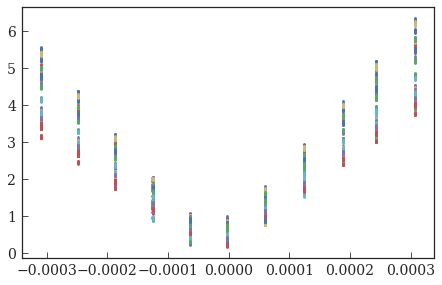

In [73]:
# sanity check 
for k in range(34):
# k=5
    plt.plot(myDataFrame['DVT50_kick'],osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))

## Get the angles turn by turn

In [116]:
from copy import deepcopy

In [128]:
# loop over all the BPM --> in vertical ! 
verticalMode = True
turnNumber = 50
BPM_n = 43

if verticalMode:
    off = 43
    transfer_matrix = Y_TM

else:
    off = 0
    transfer_matrix = X_TM

nanMatrix = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrix[:]=np.nan
myDataFrame['BPM_angle'] = [nanMatrix]*len(myDataFrame)    

for k in range(len(myDataFrame)):
    angles = deepcopy(nanMatrix)
    
    for m in range(len(BPM_name)/2):
        ydata1 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:turnNumber]).values[k] #thisBPM
        ydata2 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m+1,0:turnNumber]).values[k] #nextBPM

        angles[m,:] = getAngle(transfer_matrix[m], ydata1, ydata2) 
        
    myDataFrame['BPM_angle'].iloc[k] = angles

print('Done !')
# WRONG !

Done !


[-1.15616247  1.09502006 -1.74303342  0.35110017]
0.389275627696


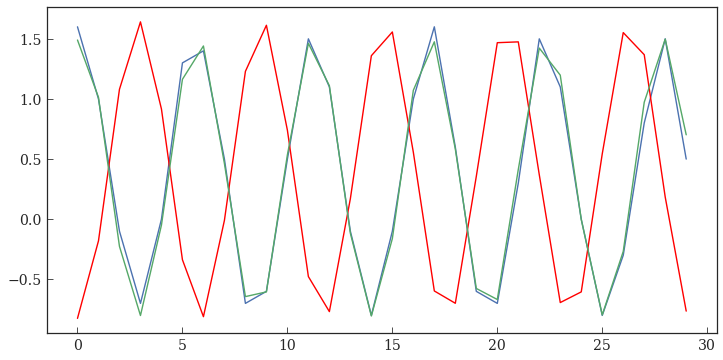

In [75]:
k = 65
m = 10 #bpm number

fig, ax  = plt.subplots(1,figsize=(12,6))
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
ax.plot(ydata,'-')

p0 = ([1.5*np.std(ydata), 0.33*pi, -pi/2, np.mean(ydata)])
ax.plot(f_to_fit(xdata, *p0), 'r')

bounds=([-np.inf, 0.01*pi, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)

yfit = f_to_fit(xdata, *p)

ax.plot(yfit)

print(p)

print(chi2[k,m])

Beta_x at PR.BPM25: 22.62961061


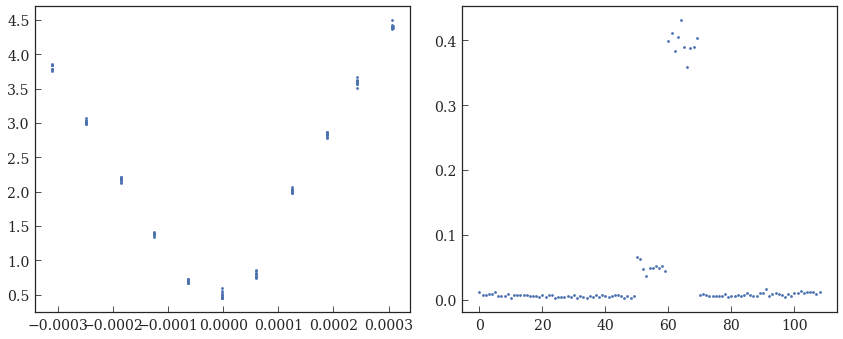

In [76]:
# manual inspection
bpm_n = 10
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(myDataFrame['DVT50_kick'],osc_amplitude[:,bpm_n],'.')
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

ax[1].plot(chi2[:,bpm_n],'.')

fig.tight_layout()

2.03833333333
1.13833333333


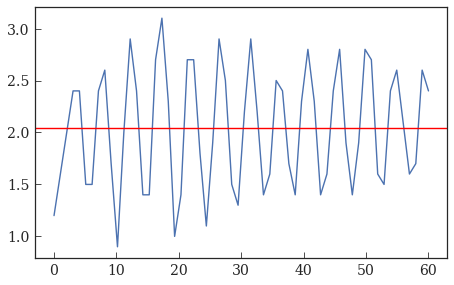

In [77]:
# another manual inspection
mySlice = chi2[:,bpm_n]
ll = np.where(mySlice>.3)
# print chi2[ll,bpm_n]

xdata = np.linspace(0,60,60)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[bpm_n,0:60]).values[ll][0]

plt.plot(xdata, ydata,'-',label='data') #factors are to adjust units in the plot

print(np.mean(ydata))
plt.axhline(y=np.mean(ydata),color='r')
print(np.max(np.abs(ydata-np.mean(ydata))))

Text(0,0.5,u'Shot number')

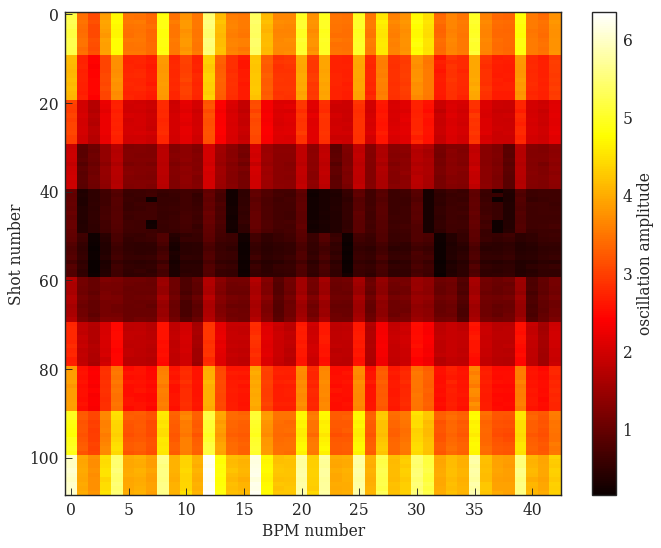

In [78]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar(label='oscillation amplitude')
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [79]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
# # bad BPM
# mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
# mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))

# myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
#bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

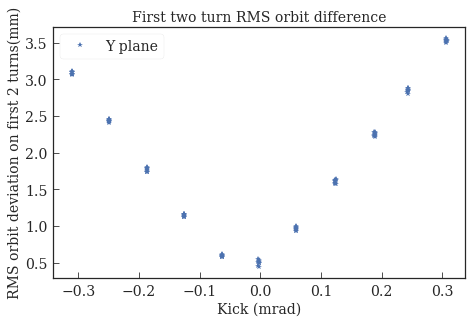

In [80]:
plt.plot(1e3*myDataFrame['DVT50_kick'],myDataFrame['deltaY_2turns'].values,'*',label='Y plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

# plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

Text(0,0.5,u'emiy_geom')

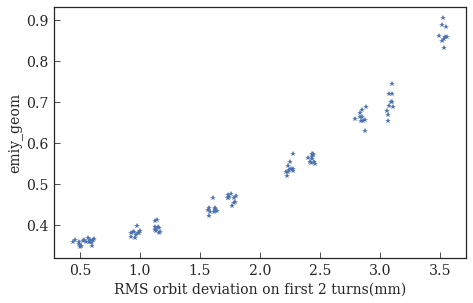

In [81]:
plt.plot(myDataFrame['deltaY_2turns'], myDataFrame['WS_geom_emittance_y'],'*',label='X plane')
plt.xlabel('RMS orbit deviation on first 2 turns(mm)')
plt.ylabel('emiy_geom')


# Methods comparison

## 1) Single BPM method

In [82]:
bpm_n1 = 10
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 22
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

At PR.BPM25 betax=22.62961061 alphax=0.02171951
Expected value for the fit a=0.0221053679261
At PR.BPM54 betax=12.48027885 alphax=0.04655777
Expected value for the fit a=0.0401500494497


Model function: a(x)^2 + c
Fit params: a=0.0263468004517+/-0.000293939468787
 c= 3.4144252544e-07+/-2.6010385331e-09
 
At PR.BPM97 betax=12.00383015 alphax=-0.05972237
Expected value for the fit a=0.0418019394201


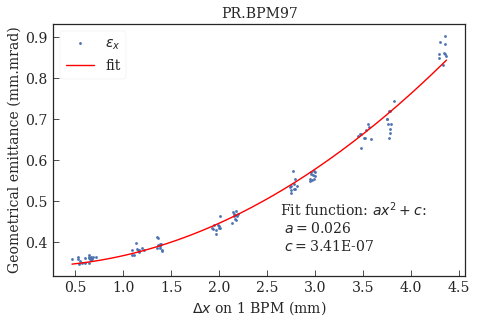

In [100]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])



plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betay[bpm_n1])+' alphax='+str(BPM_alphay[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

Model function: a(x)^2 + c
Fit params: a=0.0149395629989+/-0.000172656237317
 c= 3.43111134574e-07+/-2.67934158938e-09
 
At PR.BPM54 betay=21.86371934 alphay=0.04260766
Expected value for the fit a=0.0229104526341


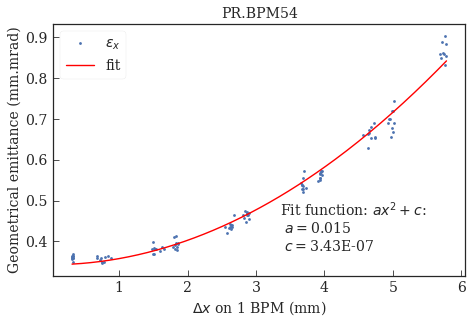

In [99]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])



plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betay='+str(BPM_betay[bpm_n2])+' alphay='+str(BPM_alphay[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n2]**2)/(2*BPM_betay[bpm_n2]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

At PR.BPM97 betax=22.49760591 alphax=0.01599718
Expected value for the fit a=0.0222302744961
At PR.BPM00 betax=22.29556133 alphax=0.13011297
Expected value for the fit a=0.0228056466018
Fit params: a=0.0137668396758+/-0.000151918601631
 c= 3.38948977388e-07+/-2.59366450529e-09
 
At PR.BPM03 betax=12.52720217 alphax=0.03566641
Expected value for the fit a=0.0399639152947
Fit params: a=0.0309128657878+/-0.000379708581937
 c= 3.44601118823e-07+/-2.83286257026e-09
 
At PR.BPM05 betax=11.99591192 alphax=0.09796604
Expected value for the fit a=0.0420808918791
Fit params: a=0.0357369522568+/-0.000345159797277
 c= 3.46608013849e-07+/-2.21606275917e-09
 
At PR.BPM07 betax=11.89811563 alphax=-0.06057049
Expected value for the fit a=0.0421776361682
Fit params: a=0.0245489587269+/-0.00027370623779
 c= 3.42588289969e-07+/-2.58977630107e-09
 
At PR.BPM10 betax=22.43426633 alphax=0.12444571
Expected value for the fit a=0.0226324926298
Fit params: a=0.0164806228113+/-0.000184714713976
 c= 3.4393818186

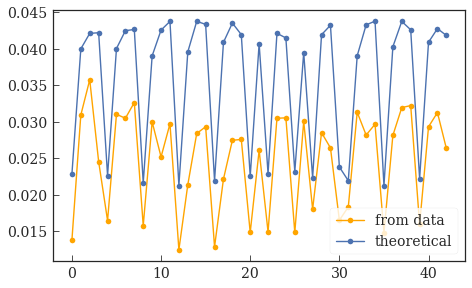

In [101]:
# look at all the BPMS
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))

def f_to_fit(x, a, c):
    return a*(x )**2 + c



param_a = np.empty(0,dtype=float)
param_c = np.empty(0,dtype=float)
expected_a = np.empty(0,dtype=float)


for bpm_n1 in range(43):
    
    osc1 = osc_amplitude[:,bpm_n1]
    print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betay[bpm_n1])+' alphax='+str(BPM_alphay[bpm_n1])
    print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1]))

    xdata = 1e-3*osc1
    ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

    p, cov = curve_fit(f_to_fit,xdata,ydata)
    err = np.sqrt(np.diag(cov))

    xfit = np.linspace(np.min(xdata),np.max(xdata),200)
    ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot
    print 'Fit params: a=' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])

    param_a = np.append(param_a, p[0])
    param_c = np.append(param_c, p[1])
    expected_a = np.append(expected_a, ((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1])) )
    
    
    print ' '


plt.plot(param_a,'o-',color='orange',label='from data')
plt.plot(expected_a,'o-',label='theoretical')
plt.legend(frameon=True)

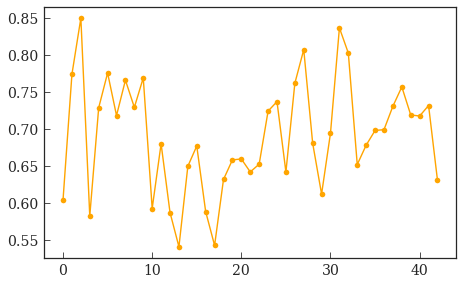

In [102]:
plt.plot(param_a/expected_a,'o-',color='orange',label='from data')


## 2) All BPM - single turn method

### Expectation value

In [87]:
exp_a_allBPM = np.mean((1 + (BPM_alphay**2))/(2*BPM_betay))

### Measurements result

Model function: a(x)^2 + c
Fit params: 
 a= 0.0398609425178+/-0.000456327764357
 c= 3.40249139085e-07+/-2.6788862087e-09
 
Expected value for the fit a=0.0359235252872


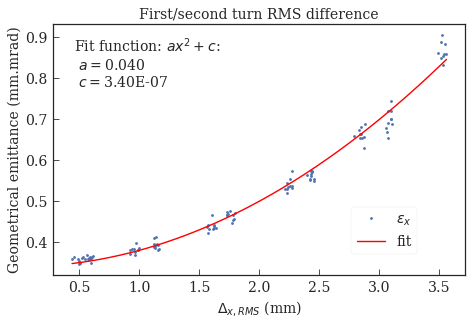

In [88]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*myDataFrame['deltaY_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: \n a= ' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.05, 0.95, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True, bbox_to_anchor=(0.9,0.3))
print ' '
print 'Expected value for the fit a='+str(exp_a_allBPM)



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('all_BPM185.eps', format='eps')

# Laslett tune shift calculation

In [89]:
myDataFrame['peakLineDensity'] = 0.58

In [90]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [91]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

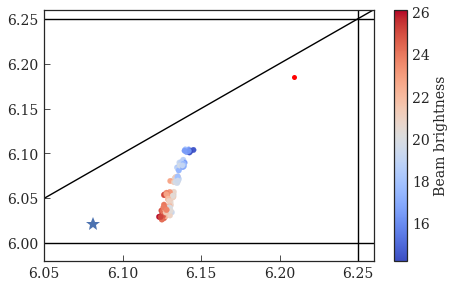

In [92]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.209
Qy = 6.185
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.05, 6.26])
plt.ylim([5.98, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.58, 0.893e-3,
              1e-6*0.777, 1e-6*0.959,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

# BPM calibration

Text(0,0.5,u'oscillation_amplitude/sqrt(beta)')

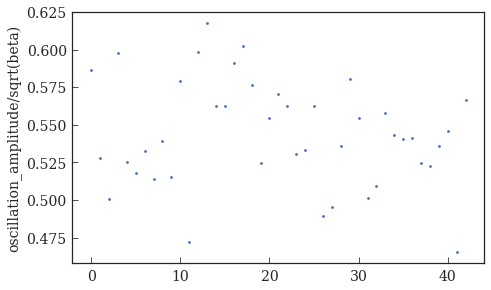

In [95]:
shot = 70
osc = osc_amplitude[shot,:]
norm_osc = osc/np.sqrt(BPM_betay)

plt.plot(norm_osc,'.')
plt.ylabel('oscillation_amplitude/sqrt(beta)')

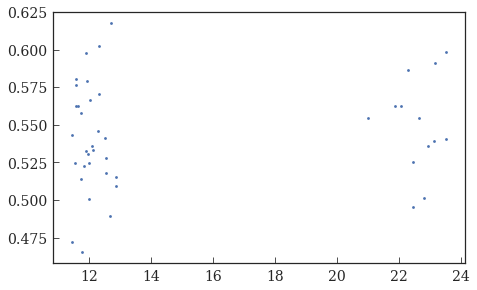

In [96]:
plt.plot(BPM_betay,norm_osc,'.')


In [97]:
BPM_betay

array([ 22.29556133,  12.52720217,  11.99591192,  11.89811563,
        22.43426633,  12.52034235,  11.88903504,  11.73845489,
        23.10996386,  12.84365279,  11.93317856,  11.4361065 ,
        23.50325922,  12.70729355,  11.5758794 ,  11.61573582,
        23.14306256,  12.29572465,  11.56634315,  11.99937001,
        22.62622561,  12.31113506,  21.86371934,  11.95362936,
        12.12141695,  22.05513478,  12.6734031 ,  22.4517249 ,
        12.07764287,  11.5744589 ,  20.99900037,  22.79991571,
        12.8619046 ,  11.73912511,  11.43404507,  23.52475135,
        12.48848538,  11.53636777,  11.82107127,  22.91630741,
        12.26713664,  11.76740458,  12.00383015])